In [1]:
import pandas as pd
import numpy as np
import os
import glob
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getcwd()
miRNAs = ['hsa-miR-21-5p', 'hsa-miR-34a-5p', 'hsa-miR-124-3p', 'hsa-miR-145-5p', 'hsa-miR-155-5p']
tools = {
    'DIANA-microT-CDS': 'DIANA-microT-CDS',
    'MirTarget': 'MirTarget',
    'miRmap': 'miRmap'
}
top_hits_sizes = list(range(20, 6001, 20))

In [5]:
# All functions

def adjusted_jaccard(set1, set2, top_hits_size):
    return len(set1 & set2) / top_hits_size * 100 if top_hits_size > 0 else 0

def jaccard_three_way(set1, set2, set3, top_hits_size):
    intersection_size = len(set1 & set2 & set3)
    return (intersection_size / top_hits_size * 100) if top_hits_size > 0 else 0

def get_sorted_genes(df):
    score_col = [col for col in df.columns if col.lower() != 'gene'][0]
    return df.sort_values(by=score_col, ascending=False)['Gene']

In [7]:
file_map = {miRNA: {} for miRNA in miRNAs}
excel_files = glob.glob(os.path.join(data_dir, "*.xlsx"))

for filepath in excel_files:
    filename = os.path.basename(filepath)
    for miRNA in miRNAs:
        if miRNA in filename:
            if "Diana microT CDS" in filename:
                tool_key = 'DIANA-microT-CDS'
                df = pd.read_excel(filepath)
                df = df.rename(columns={'gene_symbol': 'Gene', 'interaction_score': 'Diana_Score'})[['Gene', 'Diana_Score']]
            elif "miRDB" in filename:
                tool_key = 'MirTarget'
                df = pd.read_excel(filepath)
                df = df.rename(columns={'Gene Symbol': 'Gene', 'Target Score': 'miRDB_Score'})[['Gene', 'miRDB_Score']]
            elif "mirmap" in filename:
                tool_key = 'miRmap'
                df = pd.read_excel(filepath)
                df = df.rename(columns={'Gene': 'Gene', 'miRmap score': 'miRmap_Score'})[['Gene', 'miRmap_Score']]
            else:
                continue
            file_map[miRNA][tool_key] = df

In [8]:
# Analysis

tool_order = list(tools.keys())
combinations_to_analyze = list(itertools.combinations(tool_order, 2)) + [tuple(tool_order)]
results = {comb: [] for comb in combinations_to_analyze}

for comb in combinations_to_analyze:
    all_curves = []
    for miRNA in miRNAs:
        dfs = file_map[miRNA]
        top_sets = {}
        for tool in comb:
            sorted_genes = get_sorted_genes(dfs[tool])
            top_sets[tool] = [set(sorted_genes.head(size)) for size in top_hits_sizes]
        miRNA_curve = []
        for i, size in enumerate(top_hits_sizes):
            if len(comb) == 2:
                overlap = adjusted_jaccard(top_sets[comb[0]][i], top_sets[comb[1]][i], size)
            else:
                overlap = jaccard_three_way(top_sets[comb[0]][i], top_sets[comb[1]][i], top_sets[comb[2]][i], size)
            miRNA_curve.append(overlap)
        all_curves.append(miRNA_curve)
    all_curves = np.array(all_curves)
    mean_curve = np.mean(all_curves, axis=0)
    std_curve = np.std(all_curves, axis=0)
    results[comb] = (mean_curve, std_curve)

Save overlap plot as PNG? (yes/no):  yes


Saved as 'Overlap_STD_Curves_5miRNAs.png'.


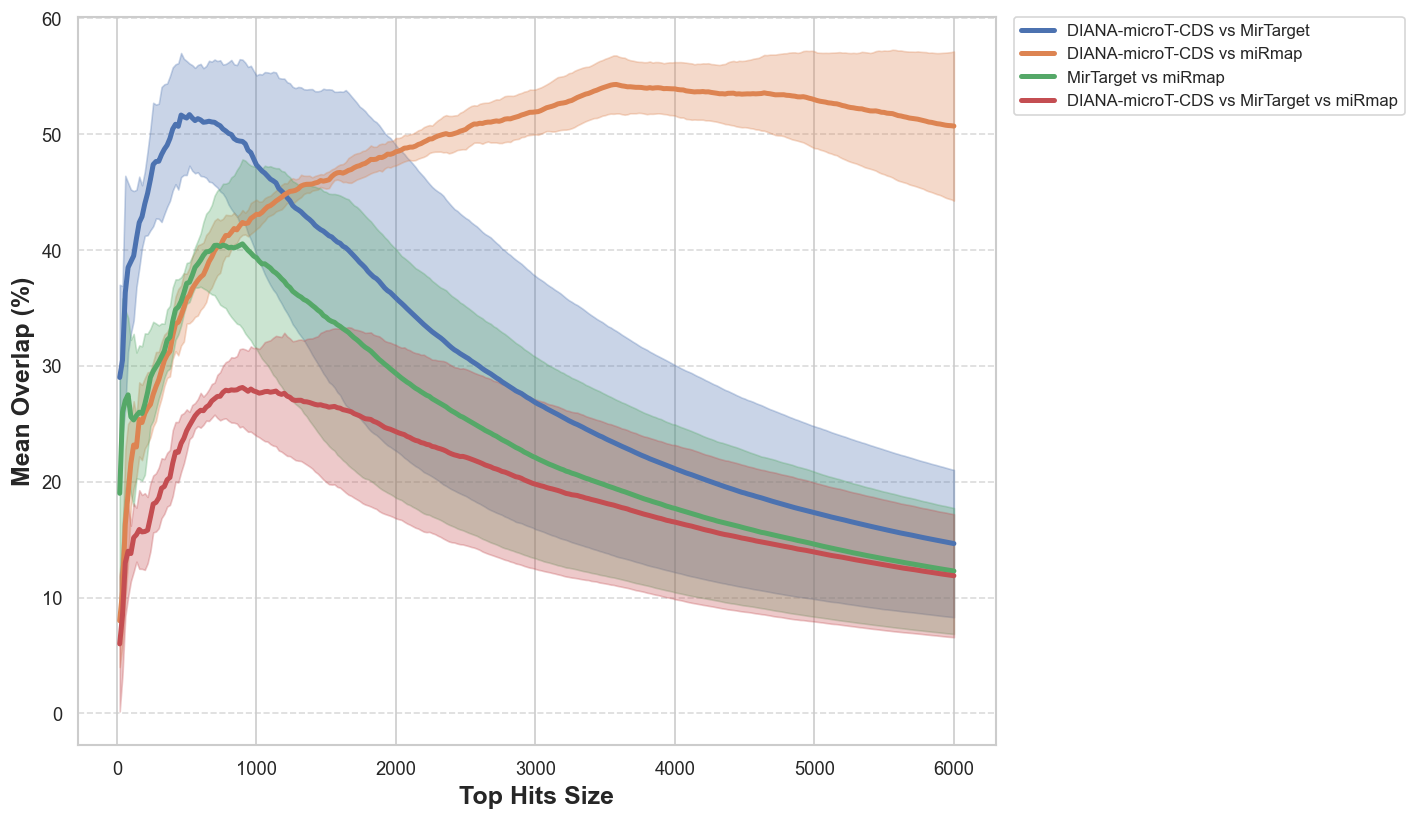

In [47]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 7), dpi=120)

for comb, (mean_vals, std_vals) in results.items():
    label = ' vs '.join([tools[t] for t in comb])
    line, = plt.plot(top_hits_sizes, mean_vals, linewidth=3, label=label)
    plt.fill_between(top_hits_sizes, mean_vals - std_vals, mean_vals + std_vals,
                     color=line.get_color(), alpha=0.3)

plt.xlabel('Top Hits Size', fontsize=15, fontweight="bold")
plt.ylabel('Mean Overlap (%)', fontsize=15, fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()

save_plot = input("Save overlap plot as PNG? (yes/no): ").strip().lower()
if save_plot == 'yes':
    plt.savefig("Overlap_STD_Curves_5miRNAs.png", format='png', dpi=300, bbox_inches='tight')
    print("Saved as 'Overlap_STD_Curves_5miRNAs.png'.")

plt.show()

In [11]:
# Summary - Top hit size for 50 % overlap

summary = []

for comb, (mean_vals, _) in results.items():
    idx_50 = next((i for i, val in enumerate(mean_vals) if val >= 50), None)
    if idx_50 is not None:
        top_hit_at_50 = top_hits_sizes[idx_50]
    else:
        top_hit_at_50 = "Not reached"

    prediction_counts = []
    for tool in comb:
        all_counts = [len(file_map[miRNA][tool]) for miRNA in miRNAs]
        prediction_counts.append(int(np.mean(all_counts)))

    tool_names = ' vs '.join([tools[t] for t in comb])
    pred_counts_str = '; '.join(map(str, prediction_counts))
    summary_line = f"{tool_names} – {top_hit_at_50} (Mean predictions: {pred_counts_str})"
    summary.append(summary_line)

print("\nOverlap Summary Report (≥50% Mean Overlap)\n")
for line in summary:
    print(line)


Overlap Summary Report (≥50% Mean Overlap)

DIANA-microT-CDS vs MirTarget – 400 (Mean predictions: 9915; 925)
DIANA-microT-CDS vs miRmap – 2360 (Mean predictions: 9915; 4733)
MirTarget vs miRmap – Not reached (Mean predictions: 925; 4733)
DIANA-microT-CDS vs MirTarget vs miRmap – Not reached (Mean predictions: 9915; 925; 4733)
